Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_path = "./Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(f"{data_path}/Train")
data_dir_test = pathlib.Path(f"{data_path}/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
number_of_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
from tensorflow.keras.models import Sequential, Model

# initialize a sequential model
model = Sequential()

# rescaling to normalize the values between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Convolutional Layer 1
model.add(layers.Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# Introducting a Dropout layer by a factor of 0.25
model.add(layers.Dropout(0.25))

# Convolutional Layer 2
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional Layer 3
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

# Flattening layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Softmax layer for Classification
model.add(layers.Dense(len(class_names), activation='softmax'))




/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,022,537 (15.34 MB)

 Trainable params: 4,022,537 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 324ms/step - accuracy: 0.1568 - loss: 2.3288 - val_accuracy: 0.3719 - val_loss: 1.7526
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.4025 - loss: 1.5915 - val_accuracy: 0.4929 - val_loss: 1.4264
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.4985 - loss: 1.3353 - val_accuracy: 0.5189 - val_loss: 1.3397
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 0.5394 - loss: 1.2429 - val_accuracy: 0.5568 - val_loss: 1.2418
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 0.5794 - loss: 1.1286 - val_accuracy: 0.6140 - val_loss: 1.0786
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - accuracy: 0.6254 - loss: 1.0164 - val_accuracy: 0.6199 - val_loss: 1.0397
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.6557 - loss: 0.9377 - val_accuracy: 0.6630 - val_loss: 0.9126
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - accuracy: 0.6937 - loss: 0

### Visualizing training results

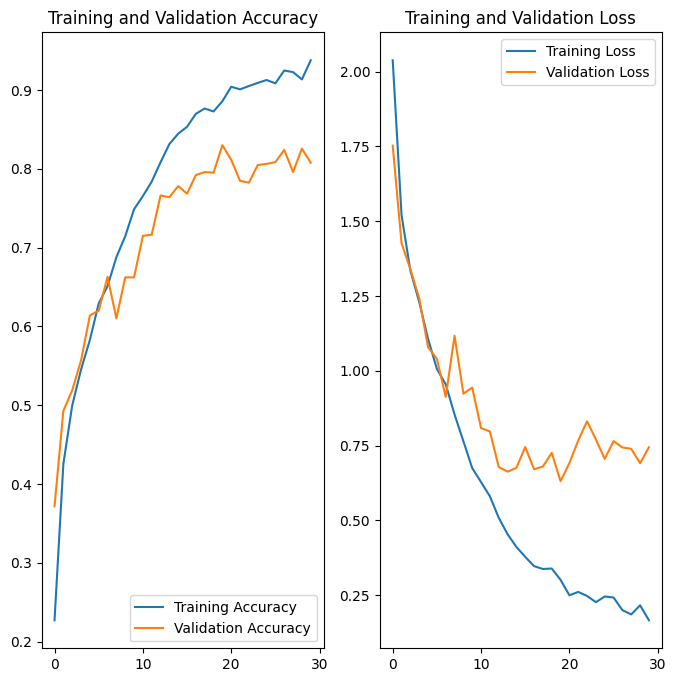

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
## Findings from the accuracy and loss plots:
1. Training Accuracy of the model increases with increase in epochs all the way to 80%.
2. Validation Accuracy does not seem to have same tendency and it peaks around 55%.
3. High training accuracy and low validation accuracy indicates overfitting by absorbing all the noise.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
# We will augment the data by Randomflip in both horizontal and vertical, RandomRotation, RandomZoom and RandomContrast
data_augmentor = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
    ])

2024-09-19 10:44:39.525729: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


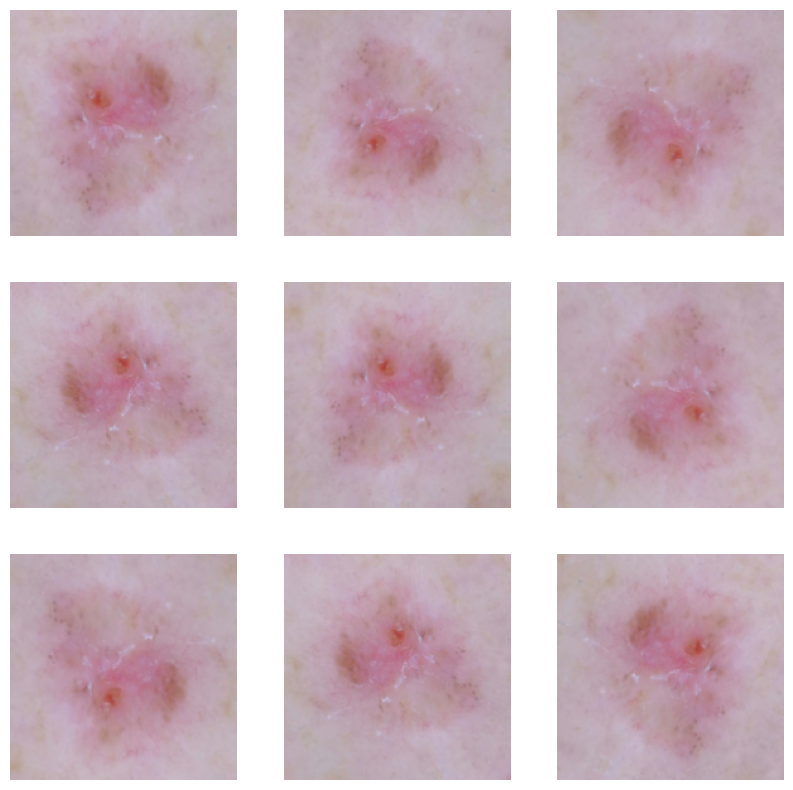

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(number_of_classes):
    augmented_images = data_augmentor(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# initialize a sequential model
model = Sequential()

# rescaling to normalize the values between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# augmentation layer
model.add(data_augmentor)

# Convolutional Layer 1
model.add(layers.Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# Introducting a Dropout layer by a factor of 0.25
model.add(layers.Dropout(0.25))

# Convolutional Layer 2
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

# Convolutional Layer 3
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Dropout(0.25))

# Flattening layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Softmax layer for Classification
model.add(layers.Dense(len(class_names), activation='softmax'))


### Compiling the model

In [19]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 308ms/step - accuracy: 0.1371 - loss: 2.4342 - val_accuracy: 0.2554 - val_loss: 1.9618
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - accuracy: 0.3295 - loss: 1.7511 - val_accuracy: 0.4180 - val_loss: 1.5133
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - accuracy: 0.4199 - loss: 1.5271 - val_accuracy: 0.4343 - val_loss: 1.4959
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - accuracy: 0.4343 - loss: 1.4774 - val_accuracy: 0.4633 - val_loss: 1.4478
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - accuracy: 0.4499 - loss: 1.4410 - val_accuracy: 0.4655 - val_loss: 1.4237
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 305ms/step - accuracy: 0.4652 - loss: 1.3978 - val_accuracy: 0.4306 - val_loss: 1.5348
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 301ms/step - accuracy: 0.4445 - loss: 1.4260 - val_accuracy: 0.4803 - val_loss: 1.3731
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 302ms/step - accuracy: 0.4621 - loss: 1

### Visualizing the results

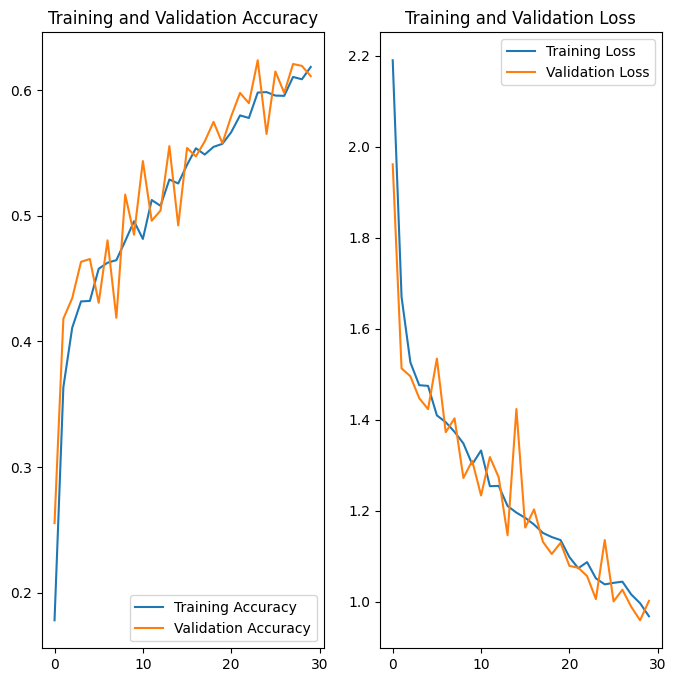

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


- Aumenting data has successfully mitigated the issue of overfitting.
- The model's training and validation accuracies are closely aligned
- However both training and validation accuracy have dropped reflecting poor performance and thus underfitting.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.


from glob import glob

## find the image path for all class labels (lesions)
path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
image_dict = dict(zip(path_list, lesion_list))
lesions_df = pd.DataFrame(list(image_dict.items()),columns = ['Path','Label'])
lesions_df.head()



,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma


Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64


/var/folders/4b/t4t_70dd1mn3yp2yl6dpsnjm0000gn/T/ipykernel_58008/2423276973.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Label", data=lesions_df, palette='pastel')


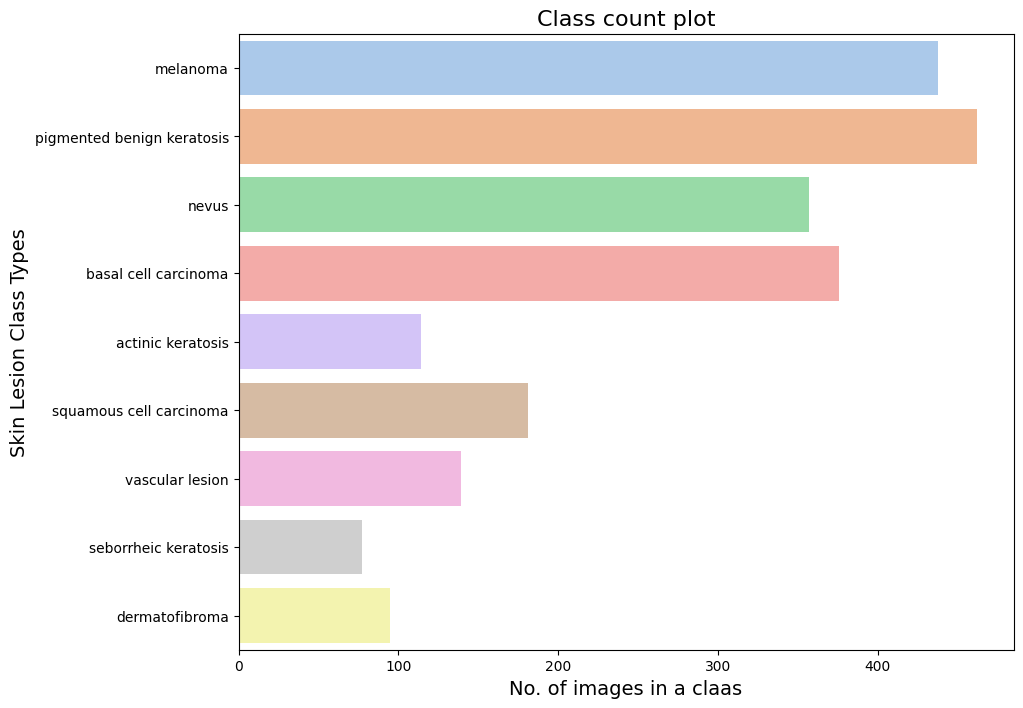

In [23]:
import seaborn as sns

## Get value counts for each class
print(lesions_df[['Label']].value_counts())

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette='pastel')
plt.title('Class count plot', fontsize=16)
plt.xlabel('No. of images in a claas', fontsize=14)
plt.ylabel('Skin Lesion Class Types', fontsize=14)
plt.show()

#### **Todo:** Write your findings here:
- Clearly the class imbalance is very evident, thus the training may be biased.
#### - Which class has the least number of samples?
- "seborrheic keratosis" with 3.44% of the total samples is the least.

#### - Which classes dominate the data in terms proportionate number of samples?
- "Pigmented benign keratosis" and "melanoma" dominate the data samples with 20.63% and 19.56% respectively.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset= str(data_dir_train) + '/'
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x321D166D0>: 100%|███| 500/500 [00:01<00:00, 278.88 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x320F86A00>: 100%|███| 500/500 [00:01<00:00, 269.58 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3220B1FD0>: 100%|█| 500/500 [00:01<00:00, 2


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x348A4F700>: 100%|███| 500/500 [00:07<00:00, 68.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x348A65F70>: 100%|█| 500/500 [00:06<00:00, 7


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x321CECA60>: 100%|███| 500/500 [00:01<00:00, 262.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x348D84430>: 100%|██| 500/500 [00:03<00:00, 144.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x321654F10>: 100%|█| 500/500 [00:02<00:00, 2


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x321CC9DC0>: 100%|███| 500/500 [00:01<00:00, 274.87 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:3]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009898.jpg_181467e0-7ff4-4f00-9fa9-0c64d7ace7ee.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000280.jpg_138c7299-7db1-4b38-aeb8-d05ff124003c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_bd2a763e-2f4c-4ae3-8a59-26bfa1f28e83.jpg']

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:3]

['melanoma', 'melanoma', 'melanoma']

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))


In [30]:
lesions_df_generated = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
lesions_df_all = pd.concat([lesions_df,lesions_df_generated])
lesions_df_all.shape

(11239, 2)

In [31]:
lesions_df_all['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [47]:
## your code goes here
# initialize a sequential model
model = Sequential()

# rescaling to normalize the values between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# augmentation layer
model.add(data_augmentor)

# Convolutional Layer 1
model.add(layers.Conv2D(16, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# Convolutional Layer 2
model.add(layers.Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# Convolutional Layer 3
model.add(layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size = (2, 2)))

# Introducting a Dropout layer by a factor of 0.25
model.add(layers.Dropout(0.25))


# Flattening layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128,activation='relu'))

# Softmax layer for Classification
model.add(layers.Dense(len(class_names), activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [48]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


#### **Todo:**  Train your model

In [49]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 276ms/step - accuracy: 0.2685 - loss: 3.1152 - val_accuracy: 0.3031 - val_loss: 8.0603
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 265ms/step - accuracy: 0.4217 - loss: 1.5042 - val_accuracy: 0.4304 - val_loss: 1.5441
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.4663 - loss: 1.3867 - val_accuracy: 0.4829 - val_loss: 1.4676
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 263ms/step - accuracy: 0.5151 - loss: 1.2766 - val_accuracy: 0.5296 - val_loss: 1.2105
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 268ms/step - accuracy: 0.5377 - loss: 1.1776 - val_accuracy: 0.4143 - val_loss: 1.6874
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 74s 264ms/step - accuracy: 0.5654 - loss: 1.1353 - val_accuracy: 0.5696 - val_loss: 1.0797
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 75s 267ms/step - accuracy: 0.5767 - loss: 1.0778 - val_accuracy: 0.5545 - val_loss: 1.1528
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 77s 274ms/step - accuracy: 0.5801 - loss: 1

#### **Todo:**  Visualize the model results

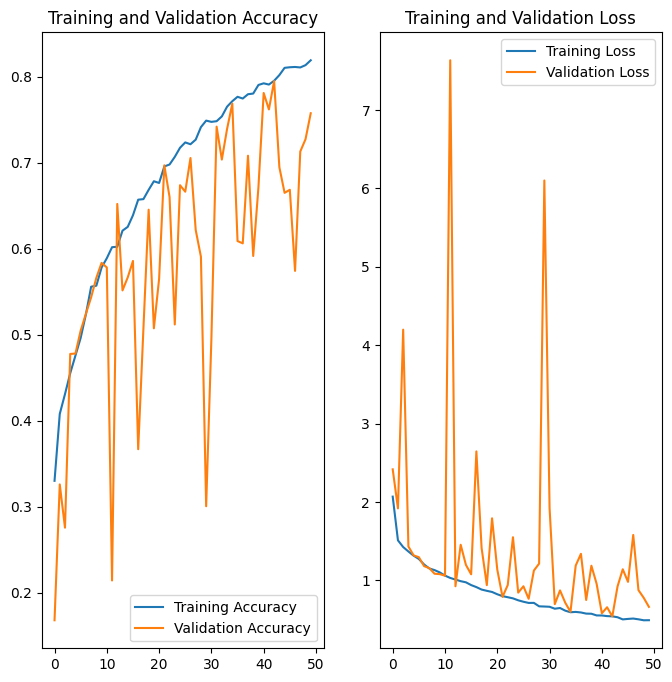

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The training accuracy and validation accuracy have increased.
- Class rebalance by using Augmentor has definitely helped in improving the accuracy.
- The training loss and validation accuracy and loss are aligned except for these steep spikes 10 & 30 epochs. 
- 40 epochs seems to be ideal with is closer to 80%


## Evaluation of the model

- We will randomly evaluate our model for a few images from the Test directory

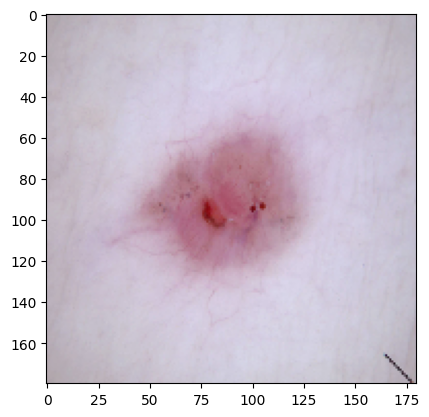

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample class: basal cell carcinoma & Predicted class: basal cell carcinoma


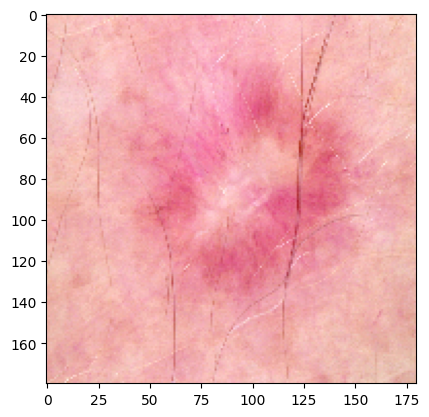

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample class: dermatofibroma & Predicted class: dermatofibroma


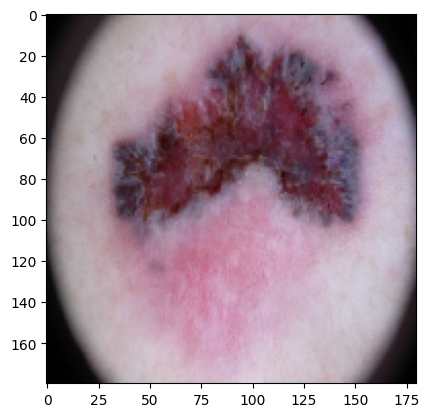

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample class: melanoma & Predicted class: melanoma


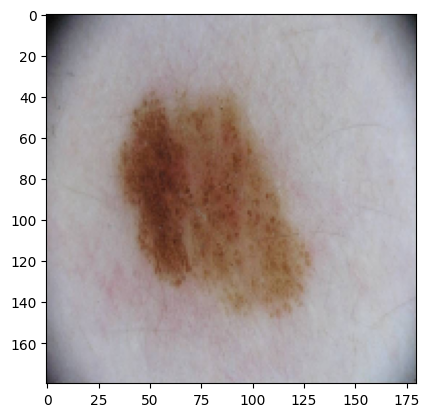

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sample class: nevus & Predicted class: nevus


In [75]:
from tensorflow.keras.preprocessing.image import load_img

def validate_sample_from_folder(folder_name, image_file_index):
    test_image = glob(os.path.join(data_dir_test, folder_name, '*'))
    test_image = load_img(test_image[image_file_index], target_size=(180, 180, 3))
    plt.imshow(test_image)
    plt.grid(False)
    plt.show()
    img = np.expand_dims(test_image, axis=0)
    prediction = np.argmax(model.predict(img))
    
    print(f"Sample class: {folder_name} & Predicted class: {class_names[prediction]}")
    
validate_sample_from_folder(class_names[1], 1)
validate_sample_from_folder(class_names[2], 2)
validate_sample_from_folder(class_names[3], 1)
validate_sample_from_folder(class_names[4], 2)